# Sampling

*Davide Gerosa (Milano-Bicocca)*


This course is based on previous work by many people. See [here]((https://github.com/dgerosa/machinelearning4physics_bicocca_2024) for credits.

---

# Action 2. Density estimation (i.e. going from the samples to the pdf)

As we will see at lenght, computing a probability density analytically is often very hard or even impossibile. Because this is so hard, the modern approach is to give up entirely and just produce samples from that pdf,  even if I don't know its functional form.

Given some samples, we then want to reconstruct the pdf. Conceptually, this is the opposite of what we did last time: we're not going from the samples to the pdf. 

The key message from today is that

### Picturing (i.e. understanding!) a pdf is not a trivial task!

Let's start with an example.

In [20]:
# Based on Ivezic v2, Figure 6.8; edited by G. T. Richards, S. R. Taylor, and D. Gerosa

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.neighbors import KernelDensity

from astropy.visualization import hist
from sklearn.mixture import GaussianMixture

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)
%config InlineBackend.figure_format='retina' # very useful command for high-res images

In [21]:
#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
# In reality nature generates data for you


random_state = np.random.RandomState(seed=0)
N = 2000 # number of data points
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
hx = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N), random_state=random_state)
                    for (mu, gamma, f) in mu_gamma_f])
random_state.shuffle(x)
x = x[x > -10]
x = x[x < 30]

These are the numbers you have. 
Say these are stellar flux measurements, or a time series from a gravitational-wave detector

In [22]:
print(x.tolist())

[8.952596638950636, 6.942533358935216, 11.857502968790328, 7.9673676256550765, 8.339793768997136, 9.104030518710326, 9.034882898224481, 9.00066149734176, 12.068202801788292, 12.43803660691054, 9.171912910373514, 9.324573877535892, 12.793456190615046, 7.649754269389245, 6.957712694613811, 5.212342443874667, -0.5858969407576264, 10.819198381549345, 6.001707605068017, 12.208739158947212, 15.623442221914667, 9.12180574588649, 12.097206156705552, 11.752914357372388, 7.624716805403909, 9.127190737797093, 4.72461107622859, 7.039304136974619, 5.608240319346324, 6.5331353251927435, 6.595590247300794, 14.350048371783956, 6.734318572151493, 7.01540998481395, 9.000751889624222, 5.691289191711737, 12.940548902826198, 8.951356409071611, 4.261082360738824, 7.074183889581066, 7.773505002260368, 7.599377398071211, 7.578337462319974, 6.661074122722392, 7.032526365073723, 3.7013711421608306, 14.14247265328622, 15.2022714128919, 4.756113643850473, 5.3798787765960085, 6.710777342736699, 7.121288020008638, 

What am I going to do with this pile of numbers to understand what the distribution looks like? 

This operation is called **density estimation**.


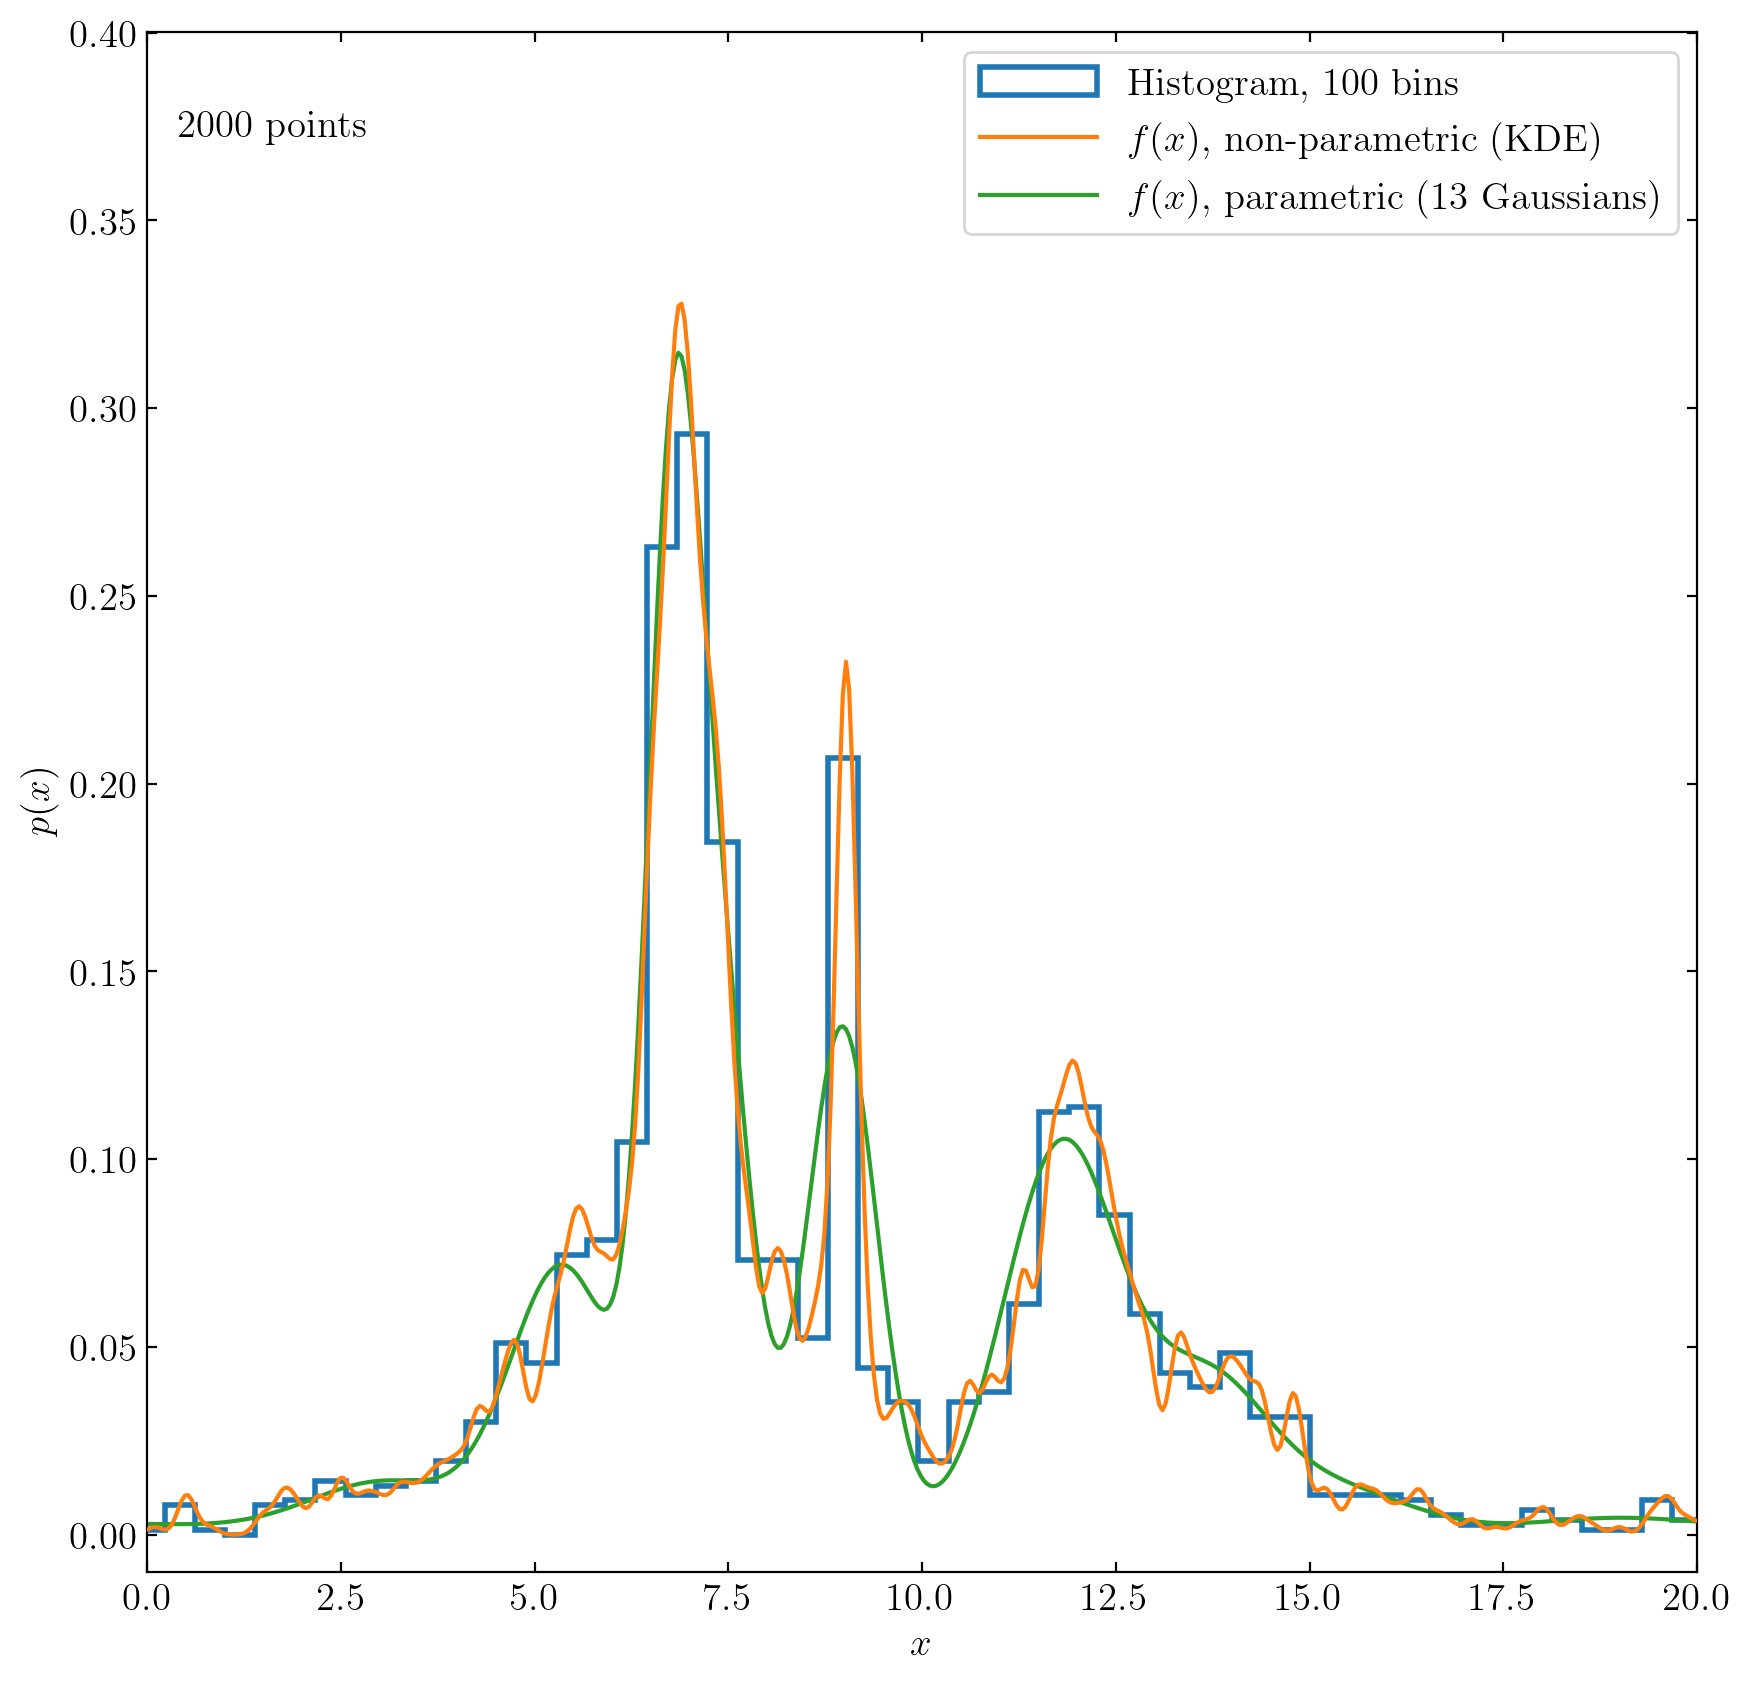

In [23]:
#------------------------------------------------------------
# plot the results
fig,ax = plt.subplots(figsize=(10, 10))
xgrid = np.linspace(-10, 30, 1000)

# True distribution: you typically don't have it! Only have the samples!
if False:
    ax.plot(xgrid, hx(xgrid), ':', color='black', zorder=3,
            label="$h(x)$, Generating Distribution")

# A simple histogram
# But try changing the number of bins!
if True:
    ax.hist(x,density=True,color='C0',bins=100,histtype='step',lw=2, label='Histogram, 100 bins')

# Something more sophisticated: Kernel Density Estimation
# But try changing the bandwith! 
if True:
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(x[:, None])
    dens_kde = np.exp(kde.score_samples(xgrid[:, None]))
    ax.plot(xgrid, dens_kde, '-', color='C1', zorder=3,
            label="$f(x)$, non-parametric (KDE)")

# Use Gaussian Mixtures with a pre-defined number of clusters (13)
if True:
    gmm = GaussianMixture(n_components=13).fit(x.reshape(-1, 1))
    logprob = gmm.score_samples(xgrid.reshape(-1, 1))
    fx = lambda j : np.exp(gmm.score_samples(j.reshape(-1, 1)))
    ax.plot(xgrid, fx(np.array(xgrid)), '-', color='C2',
            label="$f(x)$, parametric (13 Gaussians)")

# Plot cosmetics
ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)

ax.set_ylabel('$p(x)$',fontsize=14)
ax.legend(loc='upper right')

ax.set_xlabel('$x$',fontsize=14)
ax.set_xlim(0, 20)
ax.set_ylim(-0.01, 0.4001)

plt.show()

## Method 1. Histograms! <a class="anchor" id="three"></a>

Our good old friend is the histogram, and it's usually the first thing any of us do on new data. Simple, right? Not quite...

In the next few cells, I plot a normalized histogram of this data with 10 bins, 20 bins, and 100 bins. It starts off looking unimodal and Gaussian-ish, but clearly when more finely binned the data breaks up into several modes.

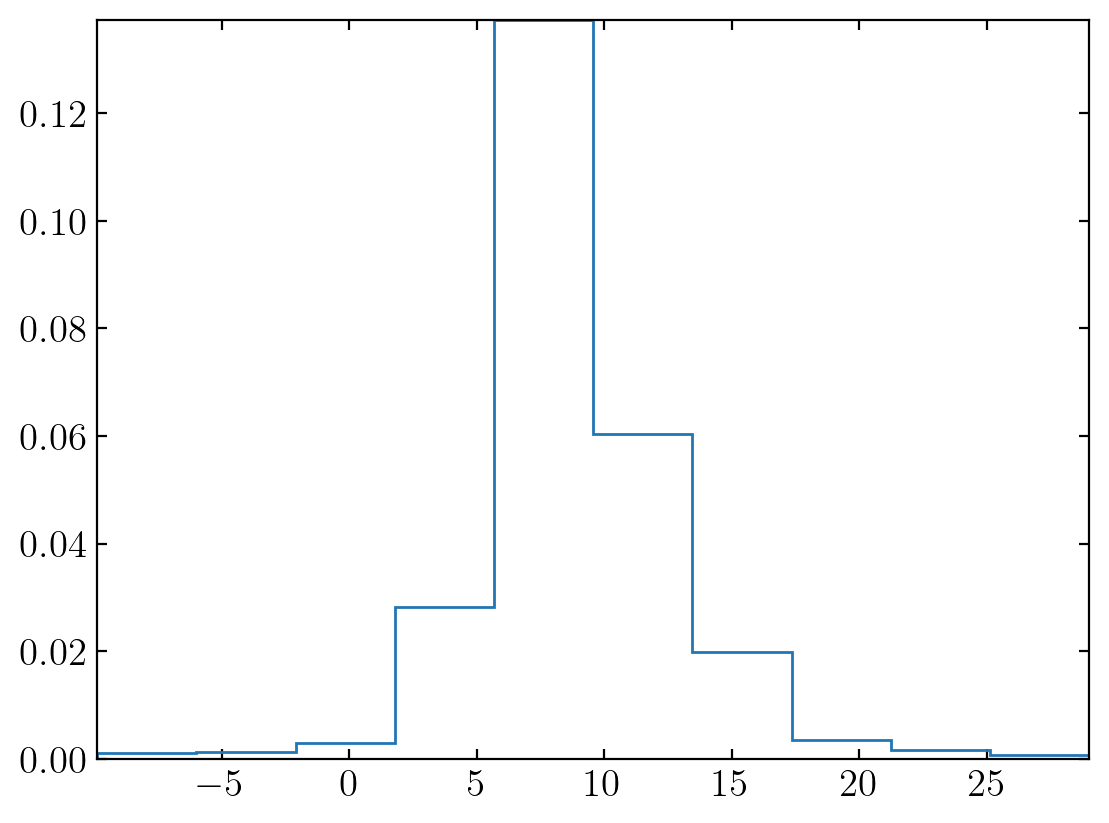

In [24]:
plt.hist(x,bins=10,histtype='step', density=True); 

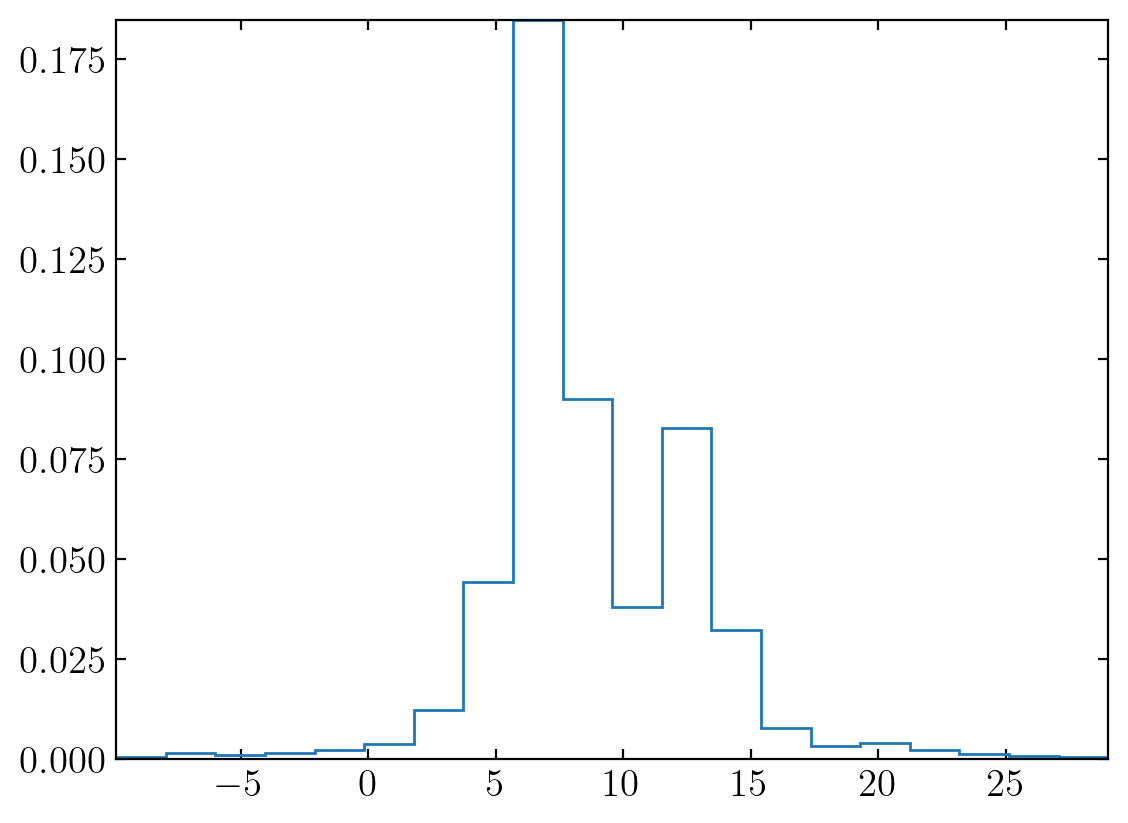

In [25]:
plt.hist(x,bins=20,histtype='step', density=True); 

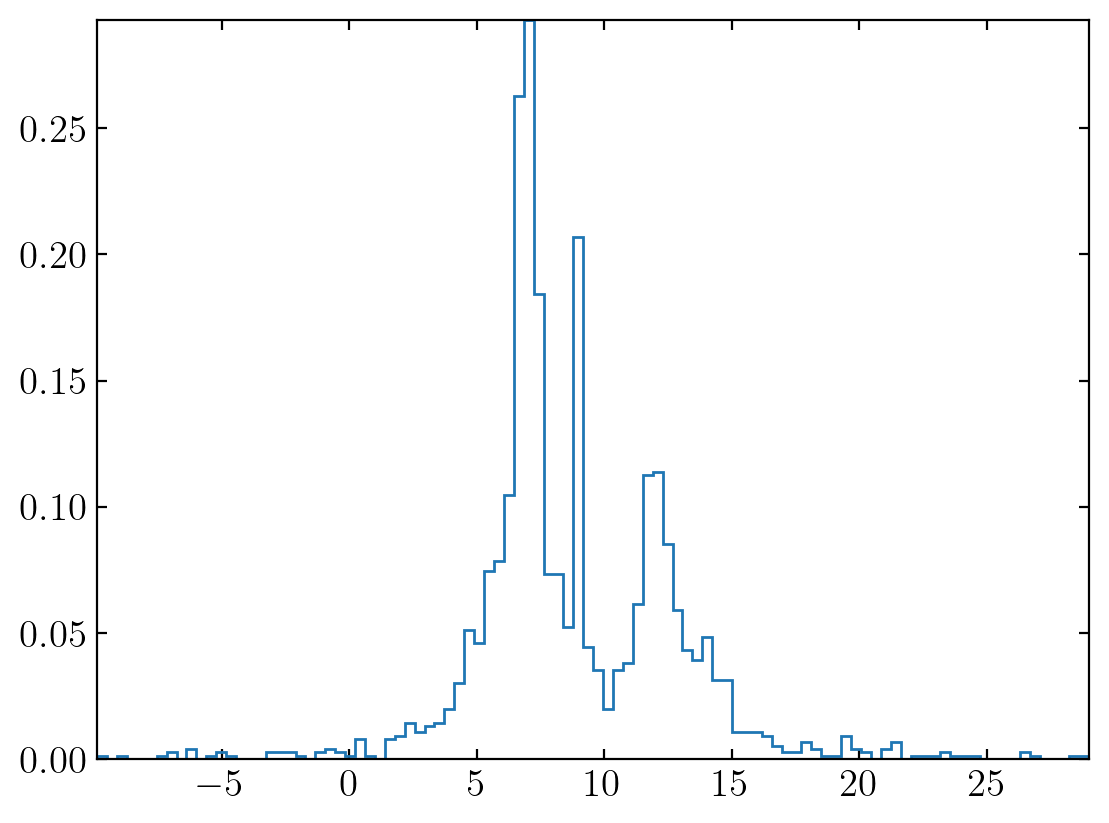

In [26]:
plt.hist(x,bins=100,histtype='step', density=True); 

How would you characterize this distribution?  Could we reasonably think of it as a normal (Gaussian) distribution that we could characterize by some mean and standard deviation?  Maybe, but even just by looking at this plot we see that it wouldn't be a particularly good description of the data.

We find that small changes in the (hyper)parameters of the histogram function *significantly* change the PDF.  That's bad, because the underlying data clearly have **not** changed.

One of the problems with histograms is that some bins end up with little (or no) data.  We can fix this by making **variable-width bin sizes** that have the ***same number of objects in each bin***.  How can we do this?

In [27]:
a = np.linspace(1,42,num=42)
print(a)
print(a[::2])
print(a[::3])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42.]
[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35.
 37. 39. 41.]
[ 1.  4.  7. 10. 13. 16. 19. 22. 25. 28. 31. 34. 37. 40.]


If you are familiar with slicing, then you know that `[::2]` and `[::3]` say to take every other index of the array or every 3rd index of the array.  So, if your array is sorted (like `a` is), then you could use this to instead define the number of values in a bin.  That is for any given value of `M`

    bins = np.append(np.sort(x)[::M], np.max(x))
    
would give bins with `M` objects in each bin.  

*Note:* you need to add the maximum value to set the right edge of the last bin.  


In [28]:
bins100 = np.append(np.sort(x)[::100], np.max(x)) 
bins30 = np.append(np.sort(x)[::30], np.max(x))
print(len(bins100),len(bins30))

21 67


In [29]:
bins100

array([-9.89016755,  4.08751476,  5.29350252,  5.94017833,  6.46762203,
        6.69633619,  6.84624115,  7.00427387,  7.19411599,  7.41433986,
        7.83432807,  8.65399202,  9.01983025,  9.49795957, 11.05452046,
       11.75129178, 12.17566754, 12.72611582, 13.86532722, 15.87905379,
       29.020106  ])

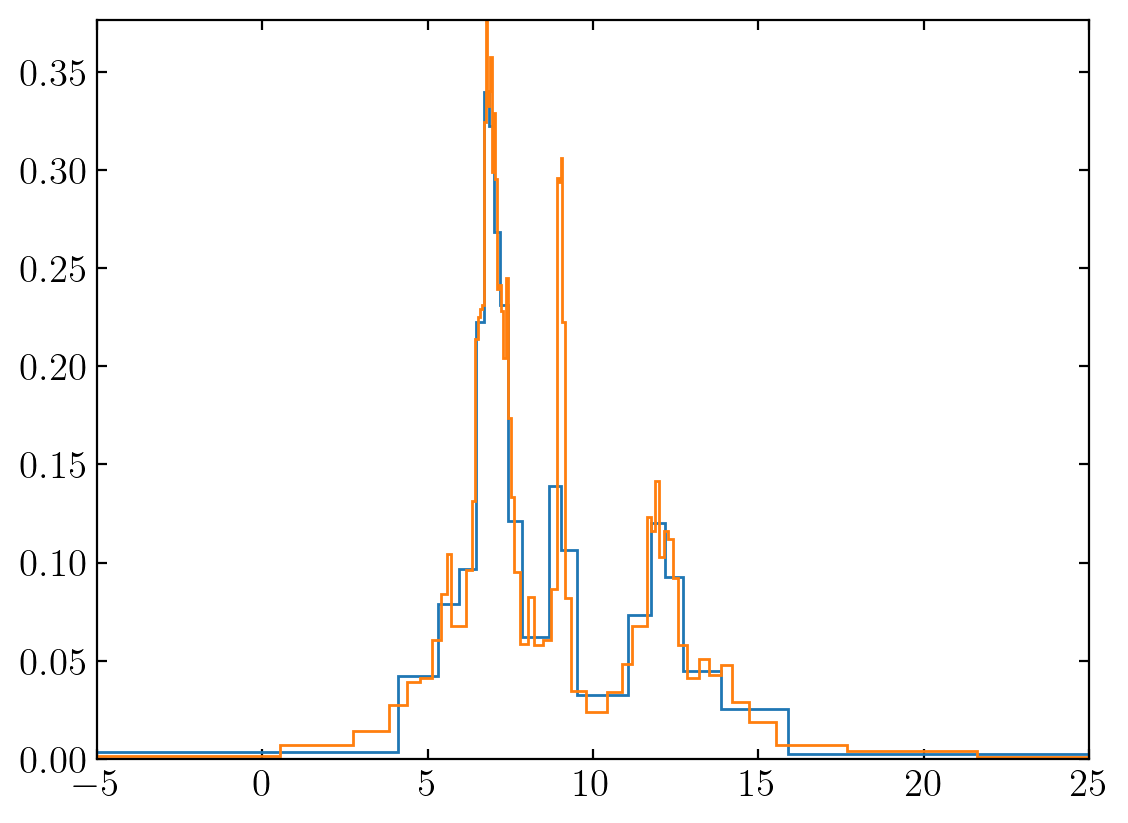

In [30]:
#Note that the underscores and the semicolon at the end both suppress the array output so that we just see the plots
_ = plt.hist(x, bins=bins100, density=True, histtype="step") #Complete
plt.hist(x, bins=bins30, density=True, histtype="step"); #Complete
plt.xlim(-5,25);

Again, this can look pretty different depending on what the number of objects you choose as the minimum for each bin and compared to the plots above.  And it looks a lot different from the plots above.

So, what is the "right" way to set the bin size? There is no "right" way, but there are some useful rules of thumb.

**"Scott's rule"** suggests that the optimal bin width is 

$$\Delta_b = \frac{3.5\sigma}{N^{1/3}}.$$

That's great, but what if we don't know the standard deviation, $\sigma$ (e.g., if the distribution isn't really Gaussian)?  

We can then instead used the **"Freedman-Diaconis rule"**: 

$$\Delta_b = \frac{2(q_{75}-q_{25})}{N^{1/3}}.$$  

Let's try that:

(-5.0, 25.0)

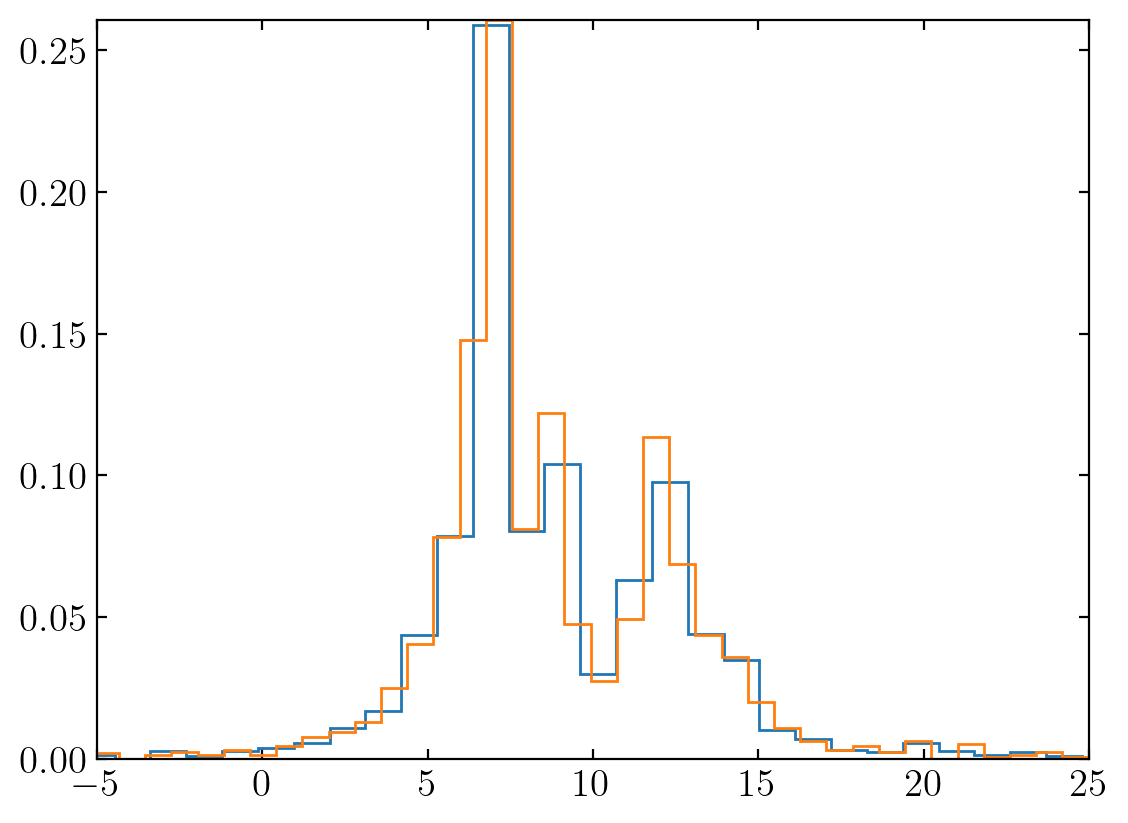

In [31]:
from astropy.visualization.hist import hist as fancyhist
_ = fancyhist(x, bins="scott", histtype="step",density=True)
_ = fancyhist(x, bins="freedman", histtype="step",density=True)
plt.xlim(-5,25)

Note that even those don't yield quite the same results!  But we can do better!

An obvious thing to do is to simply show all of the data.

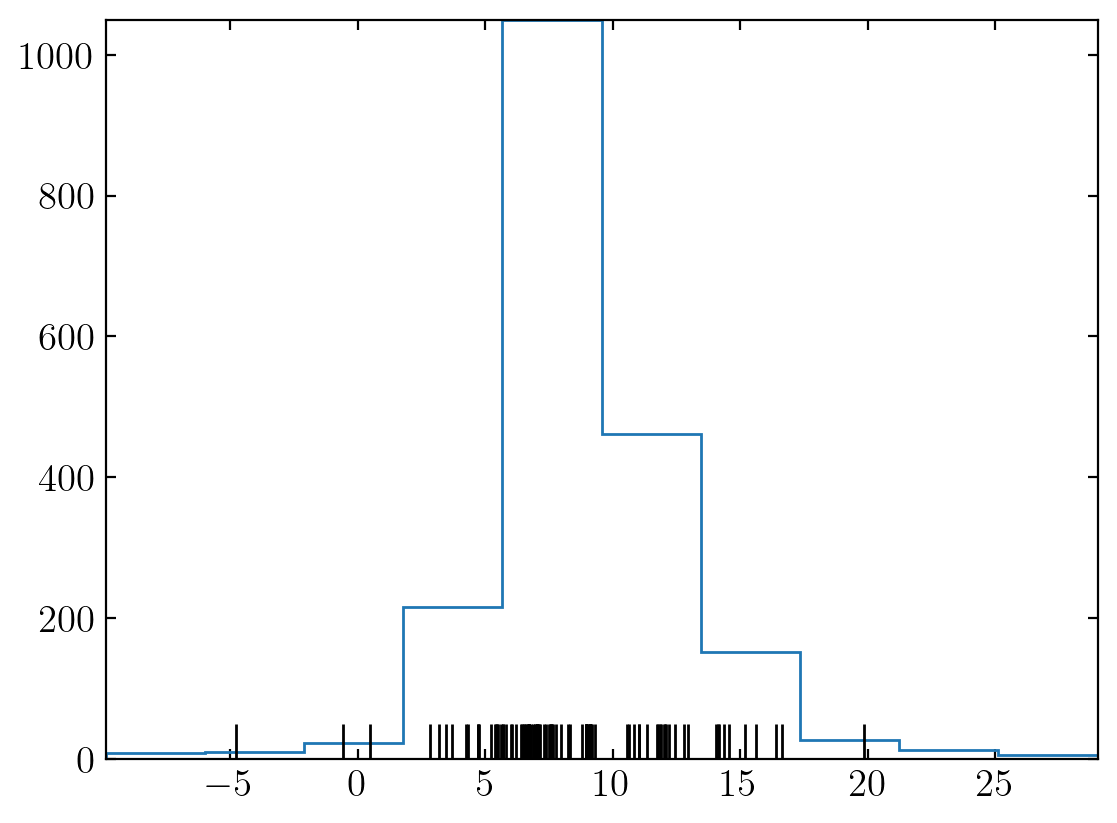

In [32]:
# execute this cell
plt.hist(x,histtype="step")
plt.plot(x[:100], 0*x[:100], '|', color='k', markersize=25) #Note markersize is (annoyingly) in *points*

This is called a **rug plot** and now we have a better idea of where most of the data and where the gaps really are (as opposed to where the binning makes them *appear* to be).  However, the markers are all piled up, so we have lost all sense of the relative numbers of objects.  Are there ~10 at x=5 or could there be 100?


**HISTOGRAMS TAKE-AWAY MESSAGE:** 

Making a histogram is the first-cut we make of data, and it's certainly one of the most sensible things to try to get a feel for the data. But we can't just do it without thinking. We need to explore bin sizes and KDE smoothing bandwidths to tease out the structure in the distributions, and overcome any finite sample effects in bins by potentially having variable bin widths.

Finally, the normalized bin height of a histogram can simply be understood as

$$ f_k = \frac{n_k}{\Delta_b N}$$

where $k$ indexes the bin, $n_k$ is the occupancy number of the bin, $\Delta_b$ is the bin width, and $N$ is the total sample size. If we want to assign **uncertainties** to each bin height (not often done, but its good practice) then we can quote

$$ \sigma_k = \frac{\sqrt{n_k}}{\Delta_b N}$$

(this relies on approximating assuming that binning is a counting experiment, which is Poisson-distributed)

# Method 2. Non parametric density estimation


## Kernel Density Estimation (KDE).


This is where **[Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE)** comes in:
- In short the idea here is to represent each data point not as a delta function, but rather as a distribution (e.g., a Gaussian).  
- Those individual distributions ("kernels") are summed up to produce the PDF.  
- One of the advantages of this is that it combines the best of 
    1. the histogram (tells us the relative height of the distribution) 
    2. the rug plot (centers the data points at the actual location of the data instead of within some arbitrary bin)
    

Just about any distribution can be used as the kernel, but the most common are a **Gaussian kernel** and an **Epanechnikov kernel**.  One downside of the Gaussian kernel is that the tails are technically infinite in extent.  So each point has some finite probability of being *everywhere*.  The Epanechnikov kernel has truncated wings.  

One still has the problem of deciding the width of the kernel (e.g., for the Gaussian the "mean" is fixed at the value of the point, but how wide should you make the Gaussian?). For now, we'll just play with the widths by hand to see what might work best.  N.B. the widths of the kernel distribution are referred to as **"bandwidth"**.

In practice, the bandwidth is almost always the key parameter of a KDE representation, the exact shape of the kerne doesn't really matter too much 

We can think of KDE as replacing the points with "clouds". Each cloud is described by the kernel $K(u)$, where $K(u)$ can be any function that is:
- smooth,
- postive definite,
- normalizes to unity, 
- has zero mean,
- has positive variance. 

A common kernel is the **Gaussian kernel** that we just used above:

$$ K(u) = \frac{1}{(2\pi)^{D/2}}\exp{(-u^2/2)}$$

where $D$ denotes the dimensionality of the data. Once a kernel is chosen the KDE at a point, $x$, is given by 

$$ \hat{f}(x) = \frac{1}{Nh^D}\sum_{i=1}^N K\left(\frac{d(x,x_i)}{h}\right),$$

where $\hat{f}$ is an ***estimator*** of our distribution.

The argument of $K$ is just some measure of the distance between $x$ and each $x_i$. Normally $d(x,x_i) = (x-x_i)$. For the gaussian kernel that makes $h=\sigma$. So, $h$ represents the "width" or what is usually called the **"bandwidth"** in this context.

**The Epanechnikov kernel is "optimal" because it minimizes the variance of the kernel density estimate**: 

$$K(x) = \frac{3}{4}(1-x^2),$$

for $|x|\le 1$ and 0 otherwise. Below is the code that produces the plot above.  


In [33]:
from sklearn.neighbors import KernelDensity
xgrid = np.linspace(x.min(),x.max(),1000)  # Use this instead of 'x' for plotting

def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

Before we try the Gaussian and Epanechnikov kernels, let's first start with a tophat using `kernel = "tophat"`, which will produce a plot much like the rug plot.

Start with `bandwidth=0.001`.  See what happens when you adjust this.

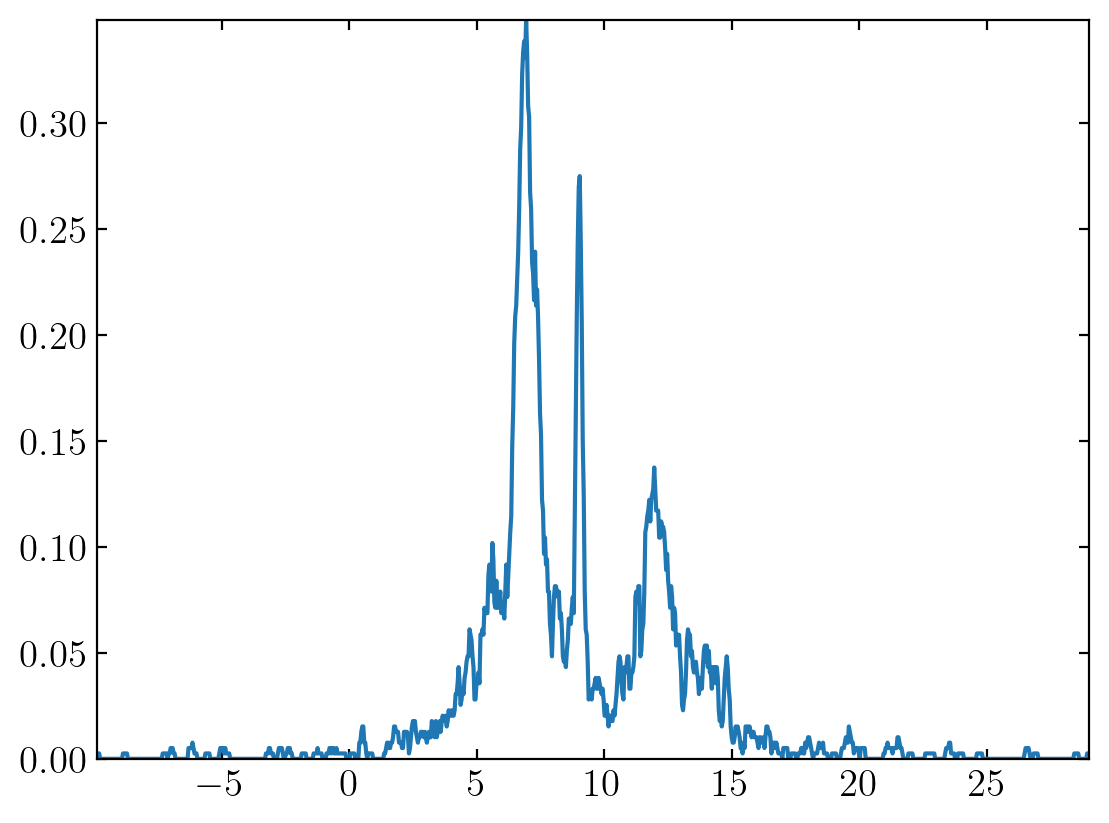

In [34]:
PDFtophat = kde_sklearn(x,bandwidth=0.1,kernel="tophat") #Complete
plt.plot(xgrid,PDFtophat) #Complete

The defaults give a result that is essentially what you would get if you made a histogram with a really large number of bins.

Now let's compare what happens when we adjust the bandwidth (which is just the width of the kernel function).  Try 
`bandwidth=0.1` and `bandwidth=0.5`.

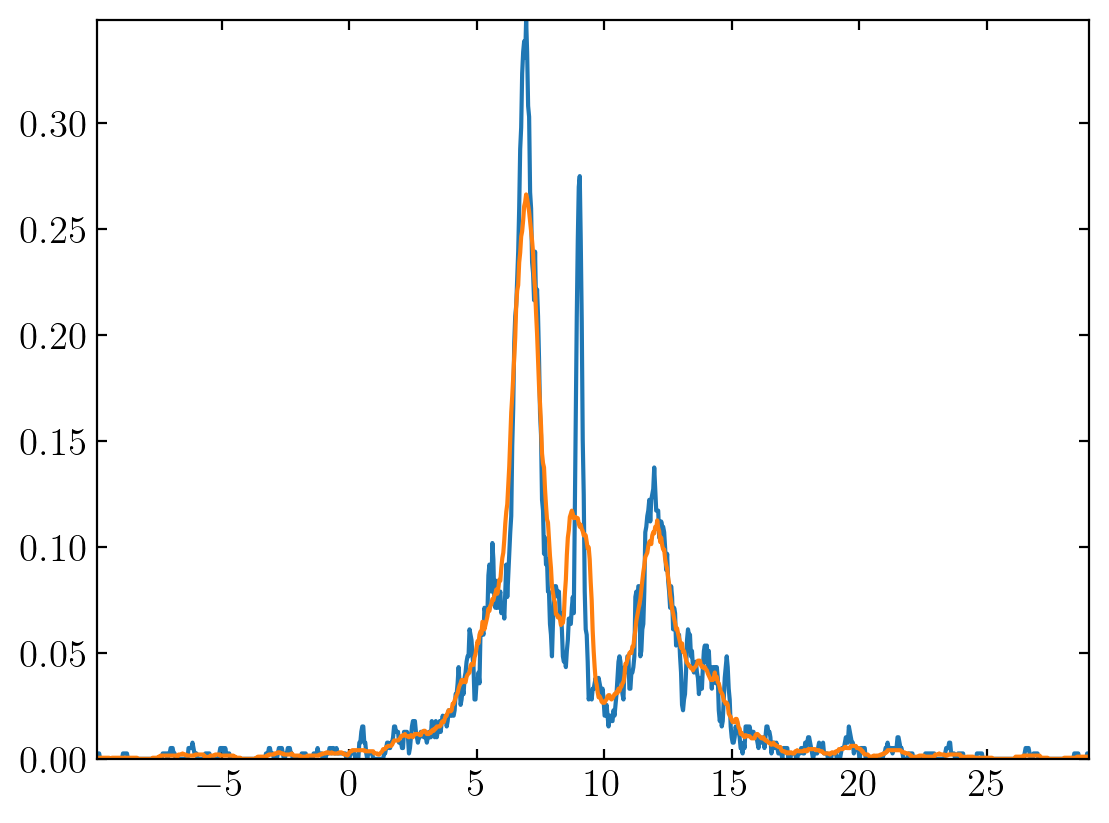

In [35]:
PDFtophat = kde_sklearn(x,bandwidth=0.1,kernel="tophat") #Complete
plt.plot(xgrid,PDFtophat)

PDFtophat = kde_sklearn(x,bandwidth=0.5,kernel="tophat") #Complete
plt.plot(xgrid,PDFtophat)

Now let's see what we get with the Gaussian `kernel="gaussian"` and Epanechnikov `kernel="epanechnikov"` kernels. Let's play with the bandwidths until we get something that looks reasonable (and roughly matches) for the two kernels.  They need not be the same.

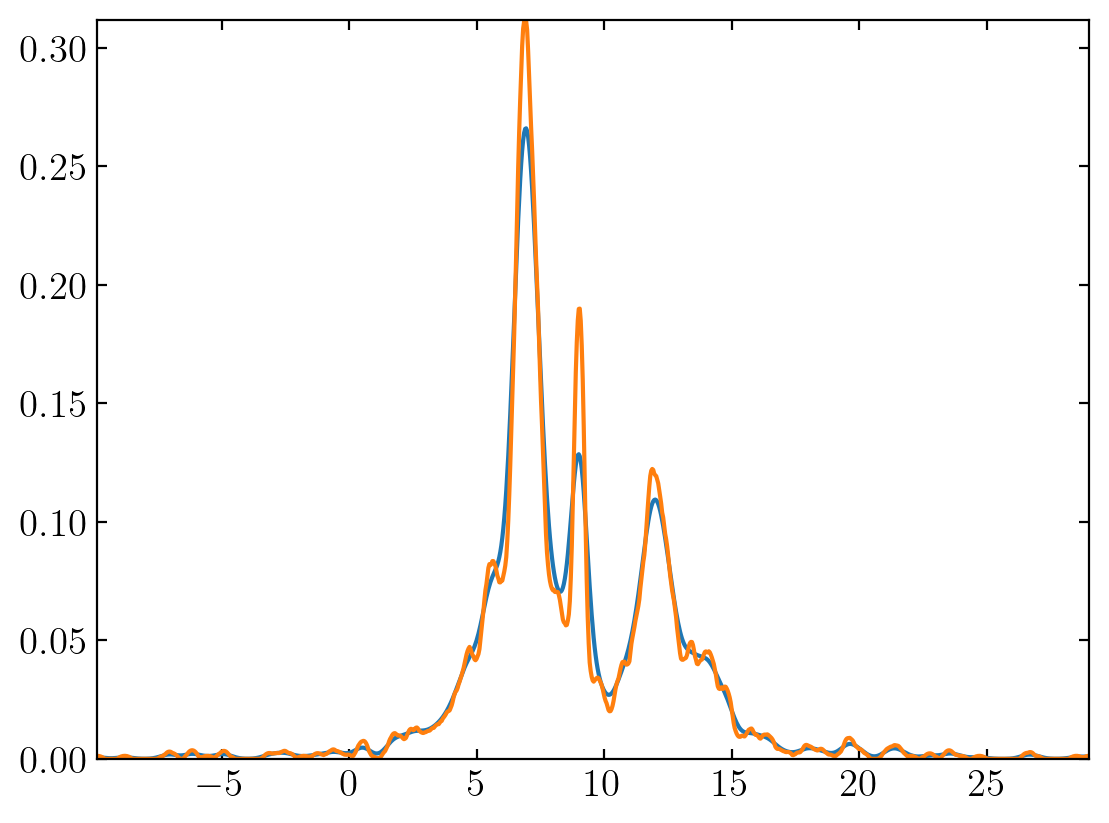

In [36]:
PDFtophat = kde_sklearn(x,bandwidth=0.3,kernel="gaussian") #Complete
plt.plot(xgrid,PDFtophat) #Complete

PDFtophat = kde_sklearn(x,bandwidth=0.3,kernel="epanechnikov") #Complete
plt.plot(xgrid,PDFtophat) #Complete

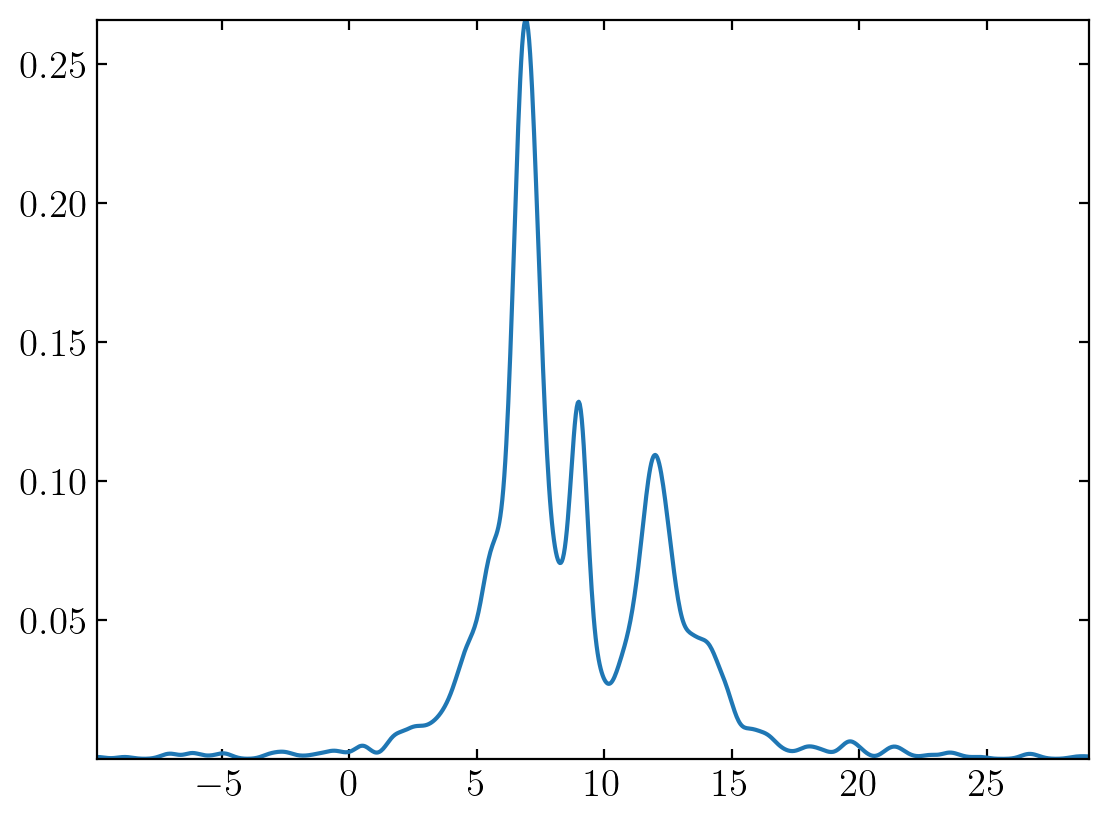

In [37]:
PDFtophat = kde_sklearn(x,bandwidth=0.3,kernel="gaussian") #Complete
plt.plot(xgrid,PDFtophat) #Complete


That's nice (and still pretty different from the histogram that we started out with).

## 2-D distributions

This works in many dimensions. 

Here is some sample code using [`sklearn.neighbors.KernelDensity`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html). Play around with this and see how it works.  Make different variations of the plot.  (For example, try `bandwidth=0.01` and `bandwidth=1.0`.)  What we are doing here is using KDE to set the plot color to indicate the relative density of the points.  This is essentially a 2-D histogram.

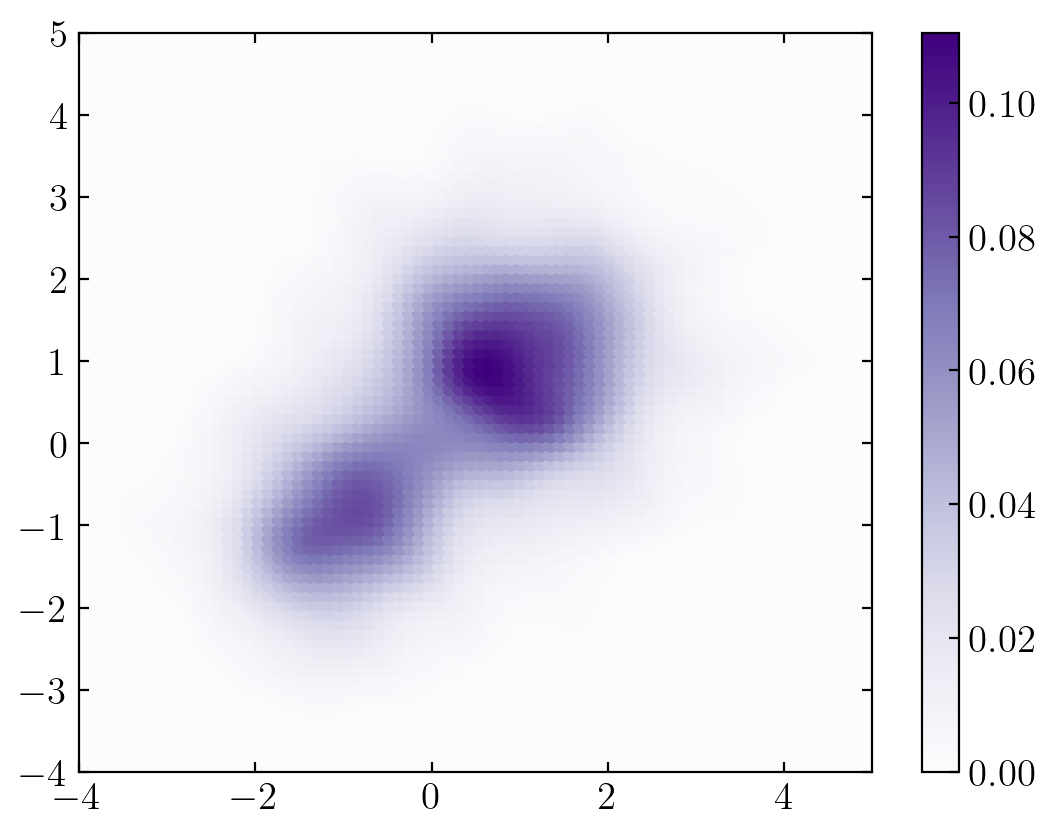

In [39]:
from sklearn.neighbors import KernelDensity

# Two 2-D normal distributions with offset centroids
# See what happens when you make changes to the next 2 lines.
X = np.concatenate([np.random.normal([-1,-1],[0.75,0.75], size=(500,2)), 
                    np.random.normal([1,1],[1,1], size=(1000,2))]) 
kde = KernelDensity(kernel='gaussian', bandwidth=0.3)
kde.fit(X) #fit the model to the data

u = v = np.linspace(-4,5,80)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()

### What's the right bandwidth? 

You're all good machine learners here... The answer is cross validation! Do a test/train splitting etc etc. 

## Nearest-Neighbor Density Estimation

Another very simple way to estimate the density of an $N$-dimensional distribution is to look to the nearest object (or the $K$ nearest objects) and compute their distances, $d_K$.  This is the [$K$-Nearest Neighbor](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) algorithm. The density at a given point, $x$ is estimated as

$$\hat{f}_K(x) = \frac{K}{V_D(d_K)},$$

where $V_D(d)$ is given generically by $\frac{2d^D\pi^{D/2}}{D\Gamma(D/2)}$ where $\Gamma$ is the complete gamma function, and this formula reduces to the usual equations for area and volume in 2 and 3 dimensions, respectively.

We can simplify this to 

$$\hat{f}_K(x) = \frac{C}{d_K^D}$$

since the constant, $C$ can be evaluated at the end.

This estimator has some intrinsic bias, which can be reduced by considering *all* $K$ nearest neighbors:
$$\hat{f}_K(x) = \frac{C}{\sum_{i=1}^K d_i^D}$$

See the [Scikit-Learn `neighbors` documentation](http://scikit-learn.org/stable/modules/neighbors.html) for more information.

Ivezic, Figure 6.5 compares a Nearest Neighbor ($k=10$) with a KDE algorithm. Let's what happens as you increase the number of neighbors used.

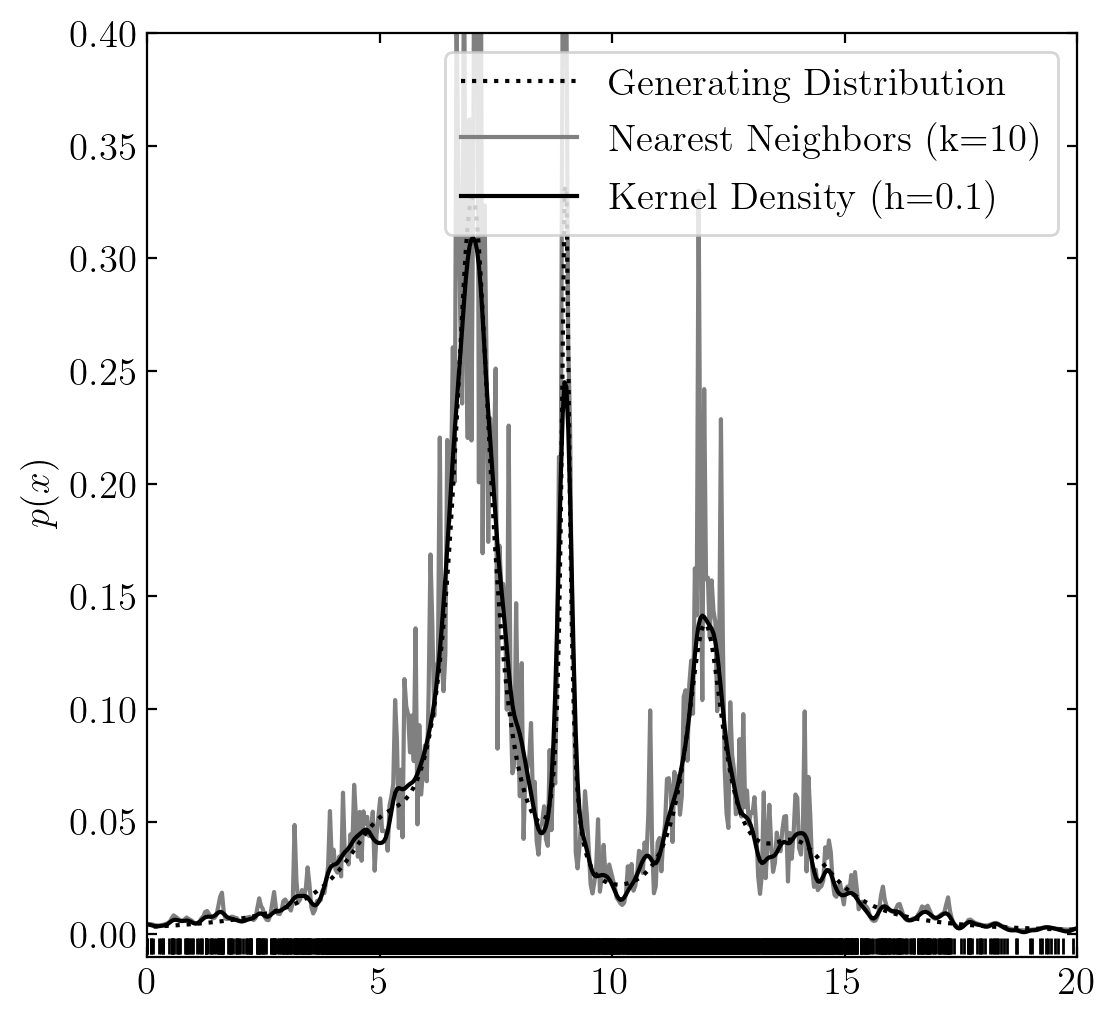

In [20]:
# Based on Ivezic, Figure 6.5
# Modified by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.neighbors import KernelDensity

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x) 
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N)) 
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(6, 6))
N = 5000
k = 10 #Number of neighbors

xN = x[:N]
t = np.linspace(-10, 30, 1000)

# Compute density with KDE
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(xN[:, None])
dens_kde = np.exp(kde.score_samples(t[:, None]))

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(xN[:, None])
dens_nbrs = nbrs.eval(t[:, None]) / N

# plot the results
plt.plot(t, true_pdf(t), ':', color='black', 
         zorder=3, label="Generating Distribution")
plt.plot(xN, -0.005 * np.ones(len(xN)), '|k')
plt.plot(t, dens_nbrs, '-', lw=1.5, color='gray', 
         zorder=2, label="Nearest Neighbors (k=%i)" % k)
plt.plot(t, dens_kde, '-', color='black', 
         zorder=3, label="Kernel Density (h=0.1)")

# label the plot
plt.ylabel('$p(x)$')
plt.legend(loc='upper right')
plt.xlim(0, 20)
plt.ylim(-0.01, 0.4001)

plt.show()

# Method 3. Parametric Density Estimation <a class="anchor" id="oneb"></a>

## Gaussian Mixture Models (GMM)

KDE centers each bin (or rather, kernel) at each point.  In a [**mixture model**](https://en.wikipedia.org/wiki/Mixture_model) we don't use a kernel for each data point, but rather we fit for the ***locations of the kernels*** in addition to the width. So a mixture model is sort of a hybrid between a traditional (fixed bin location/size) histogram and KDE. 

- Using lots of kernels may make sense if you just want to provide an accurate description of the data (as in density estimation).  
- Using fewer kernels makes mixture models more like a clustering algorithm, where you might want to identify modes in the distributions. 

Gaussians are the most commonly used components for mixture models.  So, the pdf is modeled by a sum of Gaussians:

$$p(x) = \sum_{k=1}^N \alpha_k \mathscr{N}(x|\mu_k,\Sigma_k),$$

where $\alpha_k$ are the "mixing coefficients" with $0\le \alpha_k \le 1$ and $\sum_{k=1}^N \alpha_k = 1$.

We can solve for the parameters using maximum likelihood analyis as we have discussed previously.
However, this can be complicated in multiple dimensions, requiring the use of [**Expectation Maximization (EM)**](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) methods.

Ivezic Figure 4.2 (next cell) provides an example in 1-D.

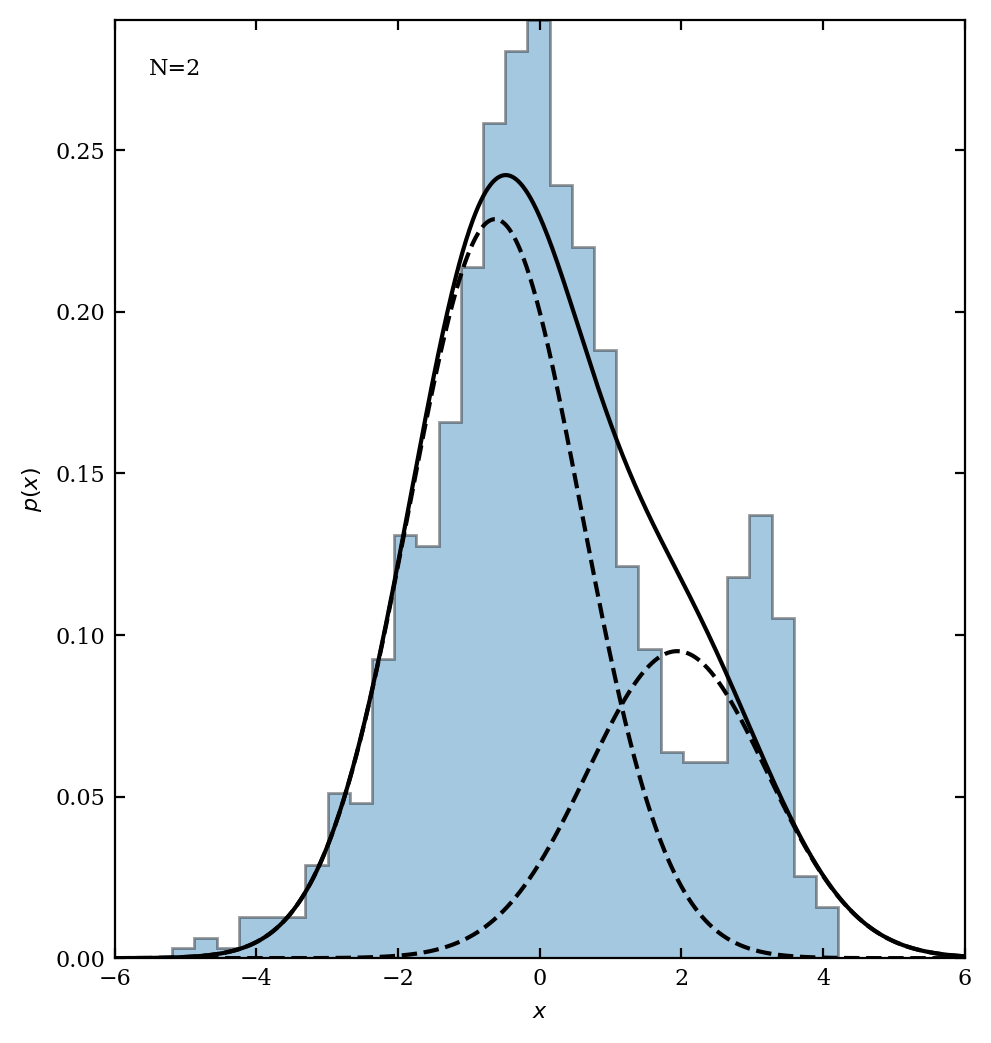

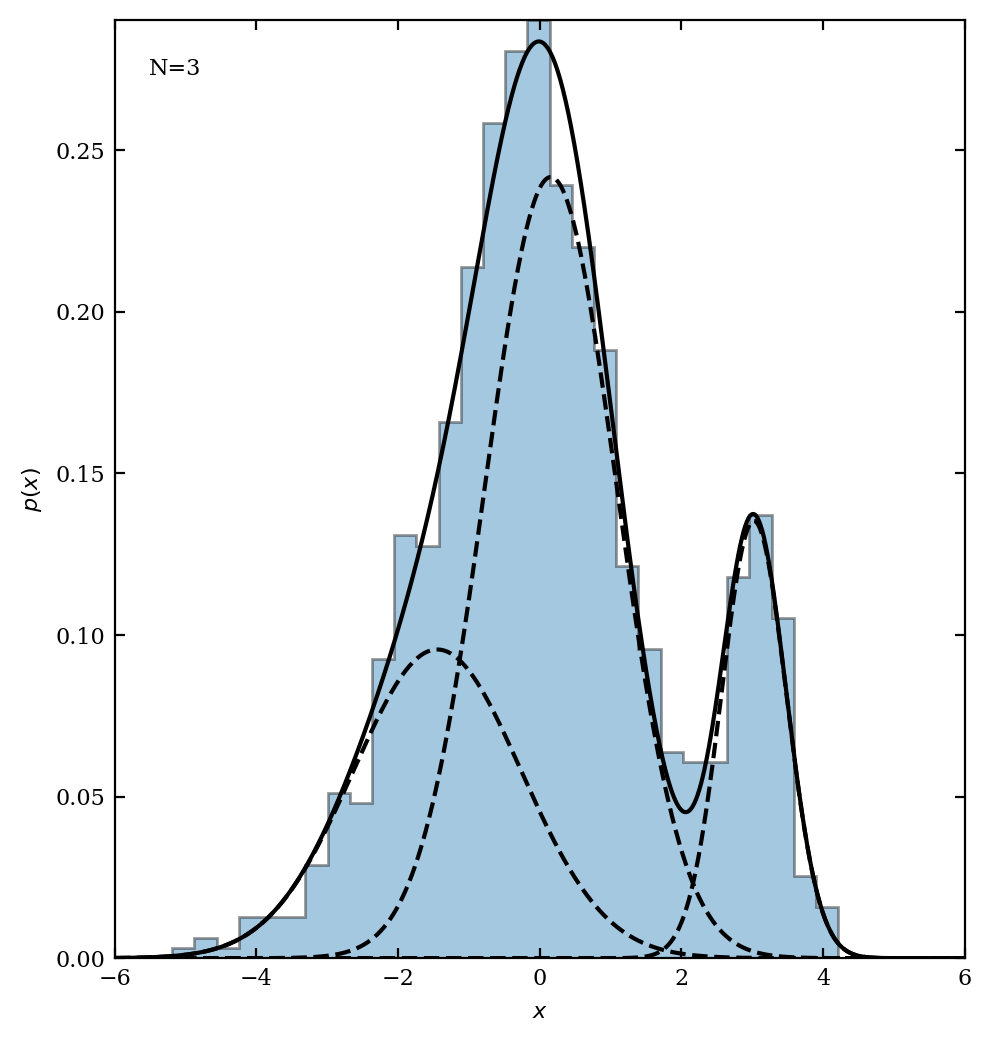

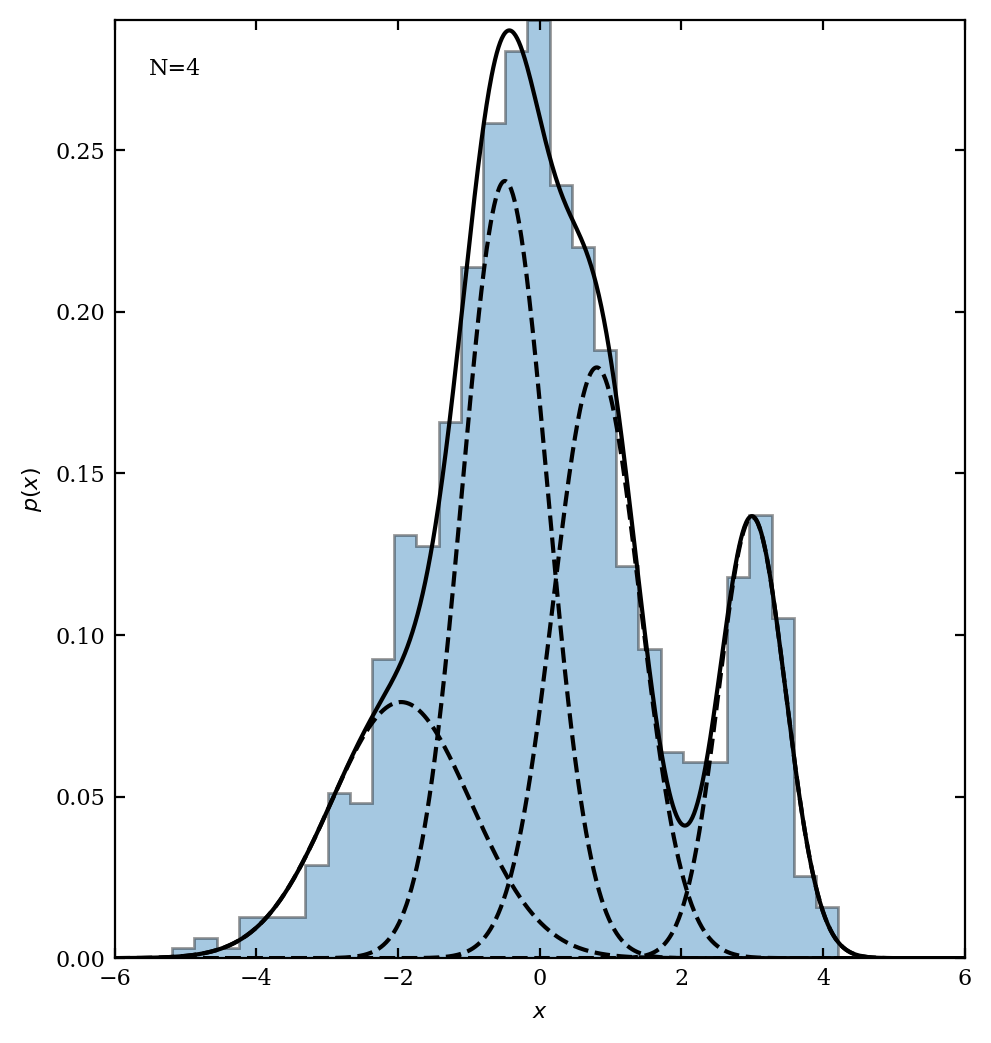

In [21]:
# Ivezic v2, Figure 4.2
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Set up the dataset.
#  We'll create our dataset by drawing samples from Gaussians.

random_state = np.random.RandomState(seed=1)

X = np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1)

#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# # fit models with 1-10 components
# N= np.arange(1, 11)
N=[2,3,4]

models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# # compute the AIC and the BIC
# AIC = [m.aic(X) for m in models]
# BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component



for M_best,n in zip(models,N):
#M_best = models[np.argmin(AIC)]
    fig = plt.figure(figsize=(20, 2*3.4))
    fig.subplots_adjust(left=0.12, right=0.97,
                        bottom=0.21, top=0.9, wspace=0.5)




    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(131)


    x = np.linspace(-6, 6, 1000)
    ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)

    logprob = M_best.score_samples(x.reshape(-1, 1))
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "N="+str(n),
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')

# # plot 2: AIC and BIC
# ax = fig.add_subplot(132)
# ax.plot(N, AIC, '-k', label='AIC')
# ax.plot(N, BIC, '--k', label='BIC')
# ax.set_xlabel('n. components')
# ax.set_ylabel('information criterion')
# ax.legend(loc=2)


# # plot 3: posterior probabilities for each component
# ax = fig.add_subplot(133)

# p = responsibilities
# p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
# p = p.cumsum(1).T

# ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
# ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
# ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
# ax.set_xlim(-6, 6)
# ax.set_ylim(0, 1)
# ax.set_xlabel('$x$')
# ax.set_ylabel(r'$p({\rm class}|x)$')

# ax.text(-5, 0.3, 'class 1', rotation='vertical')
# ax.text(0, 0.5, 'class 2', rotation='vertical')
# ax.text(3, 0.3, 'class 3', rotation='vertical')



### What's the number of components? 

You're all good machine learners here... The answer is cross validation! Do a test/train splitting etc etc. 

If you're lazy, there are some shortcuts, such as the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) and the [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion). These are already implemented in python (see comments in the code above) 


# Exam exercise! 

## Exoplanets

[Exoplanets](https://en.wikipedia.org/wiki/Exoplanet) are planets outside of the solar system. The existence of exoplanets was first confirmed in 1992. Since then the number of detected exoplanets exploded, and right now there are more than 5000! Some as are light as our Moon, and some are as heavy as 30 times the mass of Jupyter!

NASA hosts a public database with all the exoplanets discovered:

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag%20%3E0

These planets orbit far away stars. This plots shows the 2d distributions of the size of the orbit (x axis) and the mass of the planet (y axis).

![](https://elt.eso.org/public/archives/images/screen/exoplanets_elt_large.jpg)

As you see, this distribution is not uniform! There are well localized subpopulations of planets!

**Tasks**

You want to understand the pdf of exoplanets. 
- Download the database and read it with python
- Starting from these two variables (orbital radius and planet mass), construct a 2d representation using all three method we've seen: a simple 2d histogram, a KDE, and a gaussian mixture model
- Explore the distribution of other parameters in the database.
- The database provides information on the various detection methods of exoplanets (radial velocity, direct imaging etc). Investigate if some subpopulations are preferentially detected with a given method. Google this thing a bit and try to understand why that's the case.
- The database also provide the year of discovery. Again with the help of google, try to correlate this with the lauch date of big satellites.